# Tracing Invariant Units Upstream

How do these units achieve FOI, OOI and DRI simultaneously?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import handytools.navigator as nav
import spectools.models.models as mdl
from spectools.que import IQue

In [2]:
# units and layer of interest

unit = 435
hkey = 11
R_ori = 22.959854 # the response of the unit of interest in the original network

## Rank Influence by Response to Inhibition

Rank the importance of the pre-synaptic units based on how much its inhibition influences R.

A preferred way to do this would be to run natural images (or all shape images), selectively inhibit one unit, and see how much it would influence R on average. The current method is to use only the image that the unit is most reactive towards (because this is all my computer can handle).

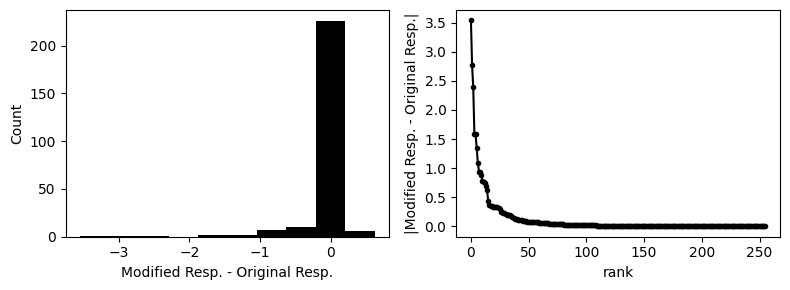

In [5]:
# rank the influence of the pre-synaptic units (in terms of how much it influences R)

diff = nav.npload("/src", "results", "subtraction_VGG16", f"max_unit={unit}_key={hkey}.npy")
diff_abs = abs(diff)
diff_sort = sorted(diff_abs, reverse=True)

fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs[0].hist(diff, color="k")
axs[1].plot(diff_sort, "k.", linestyle="-")
axs[0].set_xlabel("Modified Resp. - Original Resp."); axs[0].set_ylabel("Count")
axs[1].set_xlabel("rank"); axs[1].set_ylabel("|Modified Resp. - Original Resp.|")
plt.tight_layout(); plt.show()

In [6]:
# What are the DRI and FOI metrics of these "major" pre-synaptic units? Are they also DRI and DOI?

top = 10
preunits = np.argsort(diff_abs)[::-1][:top]

IQ = IQue()
for t in range(top):
    try:
        r2_dri = IQ("DRI", "VGG16_scale=2", 8, preunits[t])
        r2_foi = IQ("FOI", "VGG16", 8, preunits[t])
        print("Unit: ", preunits[t], ", DRI: ", r2_dri, ", FOI: ", r2_foi)
    except KeyError:
        pass

Unit:  168 , DRI:  0.8679157346487045 , FOI:  0.8809279128909111
Unit:  83 , DRI:  0.9404322728514671 , FOI:  0.6571975946426392
Unit:  214 , DRI:  0.928078681230545 , FOI:  0.7729455232620239
Unit:  209 , DRI:  0.7028330564498901 , FOI:  0.0
Unit:  22 , DRI:  0.8982657939195633 , FOI:  0.7548984885215759
Unit:  24 , DRI:  0.8717904537916183 , FOI:  0.8034345507621765
Unit:  189 , DRI:  0.7508396208286285 , FOI:  0.25950193405151367
Unit:  118 , DRI:  0.8765944615006447 , FOI:  0.9129701554775238
Unit:  196 , DRI:  0.8473910987377167 , FOI:  0.1295229196548462
Unit:  27 , DRI:  0.9341628924012184 , FOI:  0.0


## Rank Influence by "Synaptic Weight"

Rank the influence of pre-synaptic units by how much weight the filter carries.

In [7]:
# get weights of the filters

params = mdl.get_parameters("vgg16")
weights = params["features.11.weight"].detach().numpy()[unit].squeeze()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


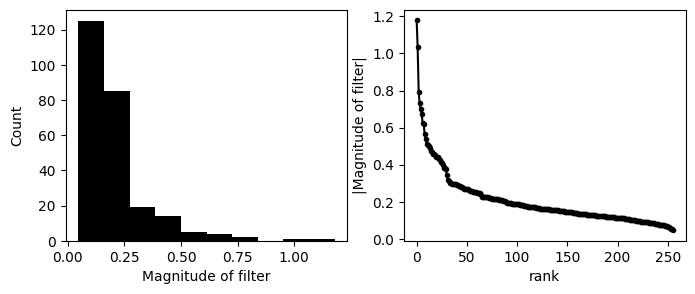

In [8]:
# rank the filter weights

mags = []
for filt in weights: # shape = (256, 3, 3)
    mag = np.abs(filt).sum()
    mags.append(mag)
mags = np.array(mags)
mags_abs = abs(mags)
mags_sort = sorted(mags, reverse=True)

fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs[0].hist(mags, color="k")
axs[1].plot(mags_sort, "k.", linestyle="-")
axs[0].set_xlabel("Magnitude of filter"); axs[0].set_ylabel("Count")
axs[1].set_xlabel("rank"); axs[1].set_ylabel("|Magnitude of filter|")
plt.show()

In [9]:
# What are the DRI and FOI metrics of these "major" pre-synaptic units? Are they also DRI and DOI?

preunits2 = np.argsort(mags_abs)[::-1][:top]
for t in range(top):
    try:
        r2_dri = IQ("DRI", "VGG16_scale=2", 8, preunits2[t])
        r2_foi = IQ("FOI", "VGG16", 8, preunits2[t])
        print("Unit: ", preunits2[t], ", DRI: ", r2_dri, ", FOI: ", r2_foi)
    except KeyError:
        pass

Unit:  24 , DRI:  0.8717904537916183 , FOI:  0.8034345507621765
Unit:  168 , DRI:  0.8679157346487045 , FOI:  0.8809279128909111
Unit:  82 , DRI:  0.9036044701933861 , FOI:  0.8780534714460373
Unit:  83 , DRI:  0.9404322728514671 , FOI:  0.6571975946426392
Unit:  166 , DRI:  0.0 , FOI:  0.0
Unit:  211 , DRI:  0.9614822939038277 , FOI:  0.0
Unit:  27 , DRI:  0.9341628924012184 , FOI:  0.0
Unit:  178 , DRI:  0.0 , FOI:  0.0
Unit:  44 , DRI:  0.9049737453460693 , FOI:  0.48292726278305054
Unit:  14 , DRI:  0.8270509392023087 , FOI:  0.6929311156272888


## Compare Two Types of "Influence Quantification"

Do they point to the same units?

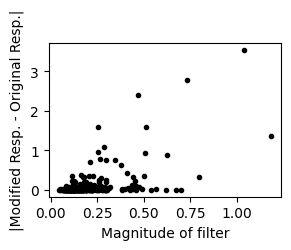

In [10]:
fig = plt.figure(figsize=(3, 2))
plt.plot(mags_abs, diff_abs, "k.")
plt.xlabel("Magnitude of filter")
plt.ylabel("|Modified Resp. - Original Resp.|")
plt.show()

## Future Work

1. Deconv net, to see what the unit and its pre-synaptic units are encoding.
2. Use a better method for influence quantification (use more images, or use the image obtained from the deconv net).